# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version - these are counterbalanced across the 2 conditions (feedback/no feedback) and image/word assignment (which images form the congruent vs. incongruent context).

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run. The first 3 are the main task images at PC 75:25, the last run is the transfer phase/image pairing (PC-50/50).

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the image is a mostly incongruent (1) or mostly congruent (0) context.

`ImagePresented` refers to the image on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each image have only one incongruent and congruent stimulus. So, there are only 8 pairings.

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3). In the No Feedback condition, the participants only got the feedback time-out.

`runStart` refers to the initiation of the countdown to begin the block; `StimTime` refers to when the image was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`StimRep` looks for direct stimulus repetitions (StroopNum).

---

### Here we'll just import Python specific packages and read in our data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%cd C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispcfb_rep\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\ispcfb_rep\\data\\csvdata\\'

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispcfb_rep\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [4]:
cdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier and understandable by other folks.

In [5]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    df['Feedback'] = df['Version'].isin([7,8,9,10,11,12])
    df.loc[df['Version'].isin([7,8,9,10,11,12]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([1,2,3,4,5,6]), 'Feedback'] = 'NoFeedback'
    
    df['Transfer'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2,3]), 'Transfer'] = 'MainTask'
    df.loc[df['RunCounter'].isin([4]), 'Transfer'] = 'TransferTask'
    
    df['DemandCue'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'DemandCue'] = 'High'
    df.loc[df['ContextType'].isin([0]), 'DemandCue'] = 'Low'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['ContextCong'] = df['DemandCue'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['DemandCue'].isin(['High']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['DemandCue'].isin(['Low']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['DemandCue'].isin(['High']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['DemandCue'].isin(['Low']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### In a typical item-specific proportion congruent paradigm, we would expect to find a congruency by proportion congruent interaction such that there is a reduced congruency difference for images that are in the "low" proportion congruent condition vs. "high" proportion congruent condition. The basic idea is that participants learn to adjust their attentional priorities for the context they are currently in, and they need to recruit more attentional focus in the low PC condition.

### Here we are looking to replicate a basic picture-word ISPC effect with our "No Feedback" group, and we are also investigating the effects of performance feedback on the ISPC effect. Because participants do not know in advance of the trial which image/context will appear, the ISPC is thought to reflect reactive control or control that is recruited in the moment. It has been hypothesized that proactive control is particularly sensitive to reward (like performance feedback), but perhaps that does not impact the ISPC/reactive control. No one has investigated how feedback can affect control-learning.

In [6]:
def mean_cueing_effect(df, dv, Filter1, Filter2, Context):
    if Context == 1:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','ContextCong'])[dv].mean()
    else:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','CSE'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(sub_means))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [7]:
mean_cueing_effect(cdat, 'RT', 'NoFeedback', 'MainTask',1)

(ContextCong
 HighC     620.207094
 HighIC    632.071502
 LowC      629.628743
 LowIC     646.546803
 Name: RT, dtype: float64, ContextCong
 HighC     4.434683
 HighIC    4.319382
 LowC      4.156935
 LowIC     4.104270
 Name: RT, dtype: float64)

In [8]:
mean_cueing_effect(cdat, 'RT', 'Feedback', 'MainTask',1)

(ContextCong
 HighC     640.344622
 HighIC    654.492436
 LowC      654.200337
 LowIC     667.524017
 Name: RT, dtype: float64, ContextCong
 HighC     4.895722
 HighIC    4.801223
 LowC      5.069972
 LowIC     4.980852
 Name: RT, dtype: float64)

What about transfer?

In [9]:
mean_cueing_effect(cdat, 'RT', 'NoFeedback', 'TransferTask',1)

(ContextCong
 HighC     610.520471
 HighIC    617.991373
 LowC      617.012096
 LowIC     625.673013
 Name: RT, dtype: float64, ContextCong
 HighC     4.391194
 HighIC    4.359160
 LowC      4.027740
 LowIC     4.166570
 Name: RT, dtype: float64)

In [10]:
mean_cueing_effect(cdat, 'RT', 'Feedback', 'TransferTask',1)

(ContextCong
 HighC     634.135615
 HighIC    642.777916
 LowC      648.203098
 LowIC     652.186043
 Name: RT, dtype: float64, ContextCong
 HighC     5.122936
 HighIC    5.038746
 LowC      5.418756
 LowIC     5.090796
 Name: RT, dtype: float64)

#### Now, what of Accuracy?

In [11]:
mean_cueing_effect(adat, 'Accuracy', 'NoFeedback', 'MainTask',1)

(ContextCong
 HighC     0.937872
 HighIC    0.918945
 LowC      0.925192
 LowIC     0.886366
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.004502
 HighIC    0.004513
 LowC      0.004351
 LowIC     0.006434
 Name: Accuracy, dtype: float64)

In [12]:
mean_cueing_effect(adat, 'Accuracy', 'Feedback', 'MainTask',1)

(ContextCong
 HighC     0.943998
 HighIC    0.928316
 LowC      0.929817
 LowIC     0.906056
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.003444
 HighIC    0.003601
 LowC      0.003103
 LowIC     0.005511
 Name: Accuracy, dtype: float64)

Transfer for Accuracy...

In [13]:
mean_cueing_effect(adat, 'Accuracy', 'NoFeedback', 'TransferTask',1)

(ContextCong
 HighC     0.945061
 HighIC    0.930699
 LowC      0.933985
 LowIC     0.917144
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.005019
 HighIC    0.005163
 LowC      0.005036
 LowIC     0.005234
 Name: Accuracy, dtype: float64)

In [14]:
mean_cueing_effect(adat, 'Accuracy', 'Feedback', 'TransferTask',1)

(ContextCong
 HighC     0.932121
 HighIC    0.934917
 LowC      0.927906
 LowIC     0.925866
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.005189
 HighIC    0.004872
 LowC      0.004545
 LowIC     0.005187
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

In [15]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispcfb_rep\data\csvdata


In [16]:
RTmeans = cdat.loc[cdat['Transfer']=='MainTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Transfer']=='MainTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans_T = cdat.loc[cdat['Transfer']=='TransferTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['RT'].mean().reset_index();
ACCmeans_T = adat.loc[adat['Transfer']=='TransferTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_T.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_T.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [17]:
%%writefile SCAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData <- read.csv('SC_ANOVA_RT.csv')

rawRTData$subject = as.factor(rawRTData$subject)
rawRTData$DemandCue = as.factor(rawRTData$DemandCue)
rawRTData$Congruency = as.factor(rawRTData$Congruency)
rawRTData$Feedback = as.factor(rawRTData$Feedback)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')

rawRTData_T$subject = as.factor(rawRTData_T$subject)
rawRTData_T$DemandCue = as.factor(rawRTData_T$DemandCue)
rawRTData_T$Congruency = as.factor(rawRTData_T$Congruency)
rawRTData_T$Feedback = as.factor(rawRTData_T$Feedback)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData_T),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')

rawACCData$subject = as.factor(rawACCData$subject)
rawACCData$DemandCue = as.factor(rawACCData$DemandCue)
rawACCData$Congruency = as.factor(rawACCData$Congruency)
rawACCData$Feedback = as.factor(rawACCData$Feedback)

SC_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_ACC_runANOVA)

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')

rawACCData_T$subject = as.factor(rawACCData_T$subject)
rawACCData_T$DemandCue = as.factor(rawACCData_T$DemandCue)
rawACCData_T$Congruency = as.factor(rawACCData_T$Congruency)
rawACCData_T$Feedback = as.factor(rawACCData_T$Feedback)

SCT_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData_T),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA)

Overwriting SCAnova.R


In [18]:
! Rscript SCAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmpc1pEjQ\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmpc1pEjQ\downloaded_packages
$ANOVA
                         Effect DFn DFd          SSn        SSd            F
1                   (Intercept)   1 118 1.985339e+08 2297748.87 1.019563e+04
2                      Feedback   1 118 5.822168e+04 2297748.87 2.989952e+00
3                     DemandCue   1 118 1.934280e+04   66010.30 3.457718e+01
5                    Congruency   1 118 2.373381e+04   23535.57 1.189939e+02
4            Feedback:DemandCue   1 118 6.706630e+01   66010.30 1.198877e-01
6           Feedback:Congruency   1 118 1.288991e+01   23535.57 6.462596e-02
7          DemandCue:Congruency   1 118 1.341662e+02   19649.53 8.056997e-01
8 Feedback:DemandCue:Congruency   1 118 2.591128e+02

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


With a larger sample size, we neither observe a 3-way nor 2-way interaction for RT or accuracy in the main task. The 2-way interaction is only trending for accuracy here. And we do not observe a group-level transfer effect in either measure. One question with this replication: is there yet another speed-accuracy trade-off here?

For example, with Experiment 1a: Participants were more accurate but slower on incongruent trials (e.g., run 3 and transfer within the no feedback group; run 2 within the feedback group). The feedback group also had a larger ISPC effect for accuracy, but a smaller ISPC effect for RT, than the no feedback group. These were evident in significant RT/acc correlations, too.

So we'll look into that for this experiment as well.

# Look at the Results Graphically

In [19]:
figurepath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\ispcfb_rep\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [20]:
def mybargraph(x,y,hue,col,order,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       col=col,
                       order=order,
                       data=data,
                       palette="colorblind",
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = ["No Feedback Group", "Feedback Group"]
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

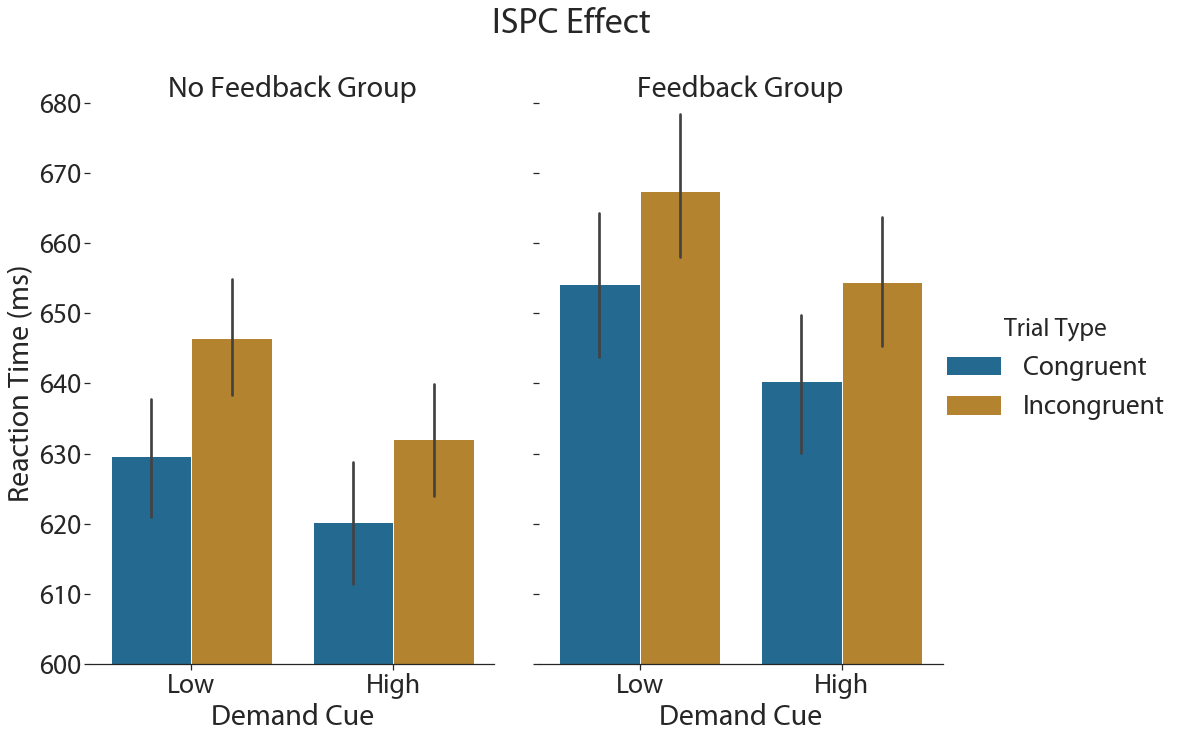

In [21]:
mybargraph("DemandCue","RT","Congruency","Feedback",["Low", "High"],RTmeans,"Demand Cue","Reaction Time (ms)","ISPC Effect","Trial Type",600,680,"ISPC_RT_maintask.png",10)

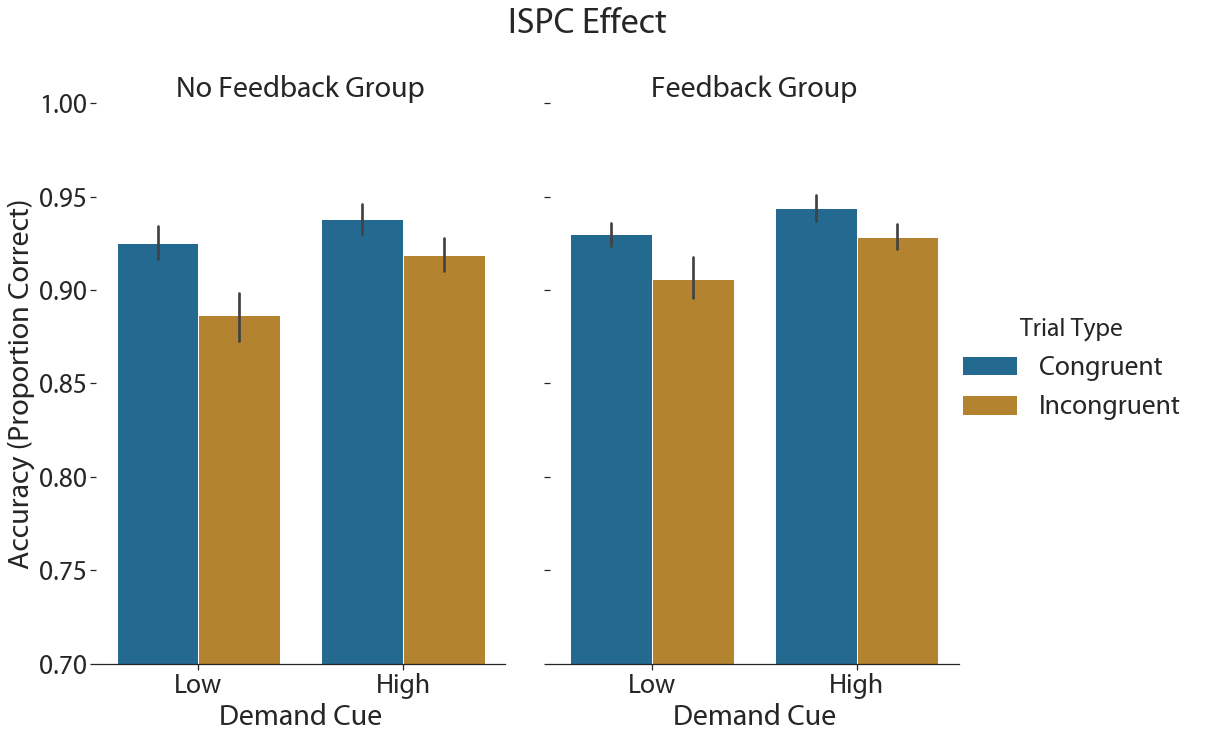

In [22]:
mybargraph("DemandCue","Accuracy","Congruency","Feedback",["Low", "High"],ACCmeans,"Demand Cue","Accuracy (Proportion Correct)","ISPC Effect","Trial Type",0.7,1.0,"ISPC_ACC_maintask.png",0.05)

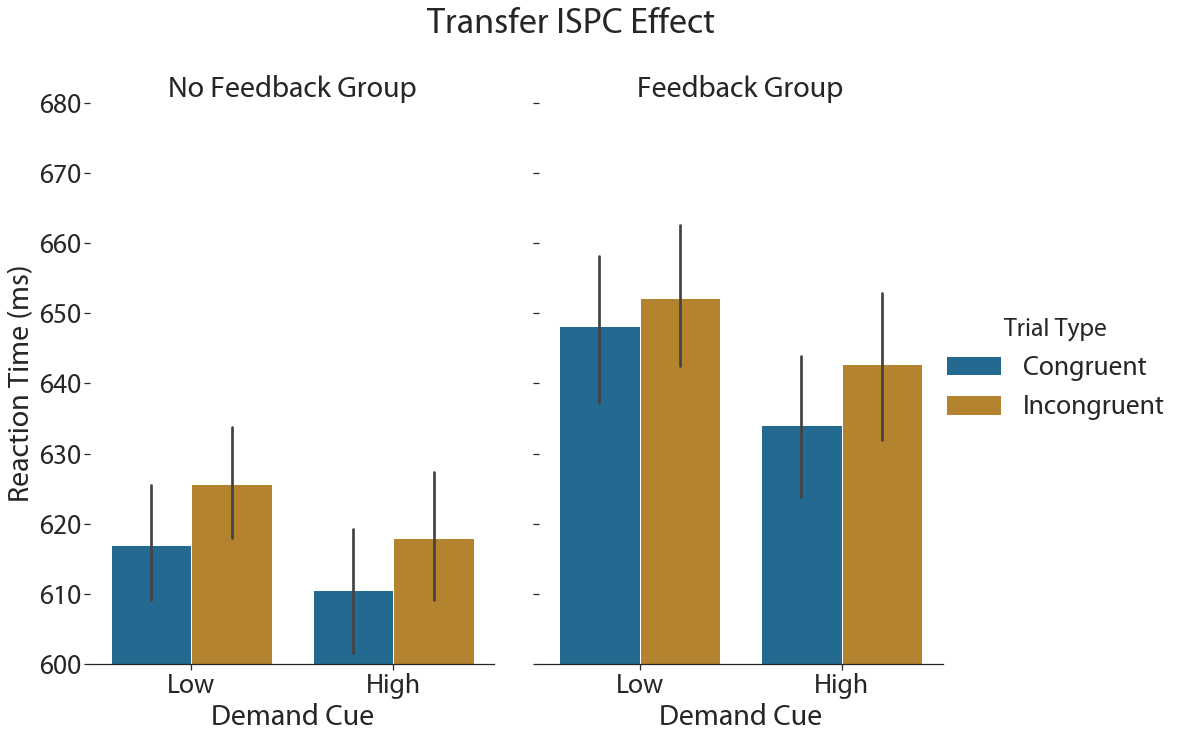

In [23]:
mybargraph("DemandCue","RT","Congruency","Feedback",["Low", "High"],RTmeans_T,"Demand Cue","Reaction Time (ms)","Transfer ISPC Effect","Trial Type",600,680,"ISPC_RT_transfertask.png",10)

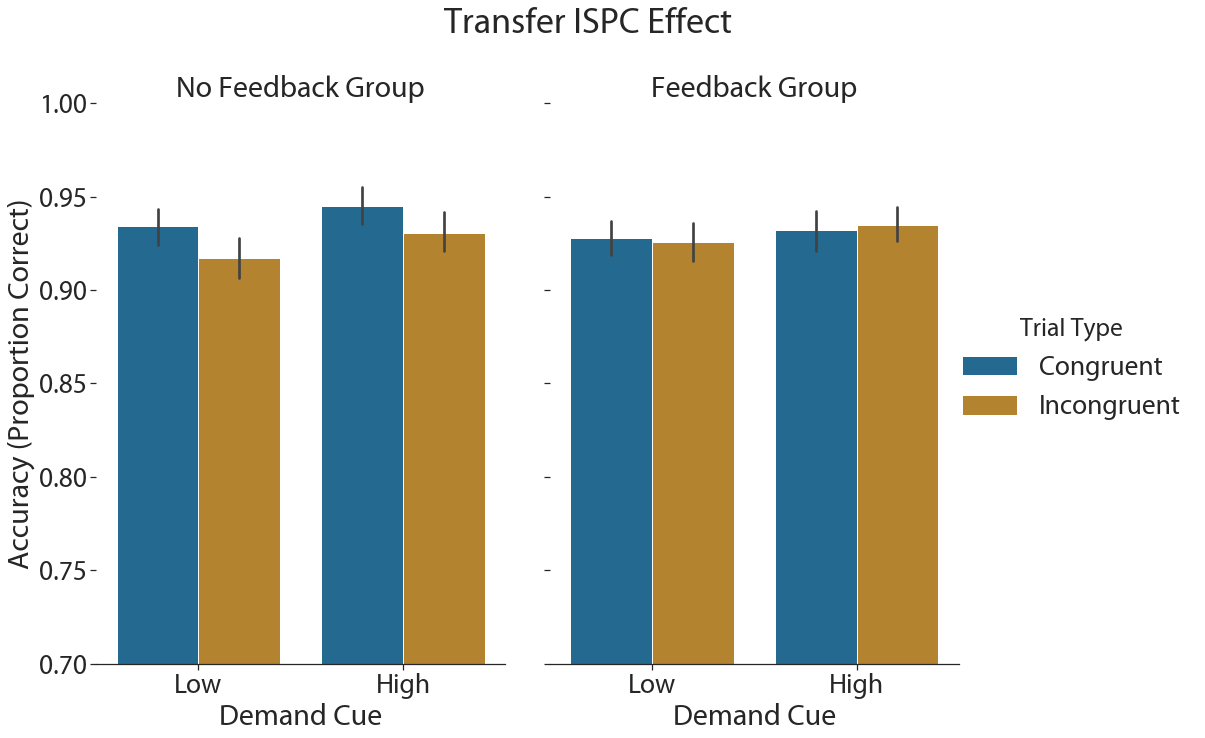

In [24]:
mybargraph("DemandCue","Accuracy","Congruency","Feedback",["Low", "High"],ACCmeans_T,"Demand Cue","Accuracy (Proportion Correct)","Transfer ISPC Effect","Trial Type",0.7,1.0,"ISPC_ACC_transfertask.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction
##### also used to calculate inverse efficiency scores, test RT/acc trade-off

In [25]:
FBsubslim = 120;
NoFBsubslim = 60; #subs 1-60 in the list are no fb grp, while 61-120 are fb

In [26]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
NoFB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();
NoFB_ACC = pd.DataFrame();

In [27]:
def create_wide_df(df,dfname,dv,Group,lim1,lim2):
    lists = [[] for list in range(0,9)]
    data = df[df.Feedback == Group]
    
    for ID in range(lim1, lim2):
        sub = data[data.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Transfer == 'MainTask']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Transfer == 'TransferTask']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]

In [28]:
create_wide_df(cdat,FB_RT,'RT','Feedback',NoFBsubslim+1,FBsubslim+1);

In [29]:
create_wide_df(cdat,NoFB_RT,'RT','NoFeedback',1,NoFBsubslim+1);

In [30]:
create_wide_df(adat,FB_ACC,'Accuracy','Feedback',(NoFBsubslim+1),(FBsubslim+1));

In [31]:
create_wide_df(adat,NoFB_ACC,'Accuracy','NoFeedback',1,NoFBsubslim+1);

In [32]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [33]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [34]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [35]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [36]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

In [37]:
SC_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 0, 1)

In [38]:
SCT_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 1, 1)

In [39]:
SC_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 0, 0)

In [40]:
SCT_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 1, 0)

In [41]:
#interaction effects - both groups
SC_RT = SC_RT_NoFB.append(SC_RT_FB)
SC_ACC = SC_ACC_NoFB.append(SC_ACC_FB)
SCT_RT = SCT_RT_NoFB.append(SCT_RT_FB)
SCT_ACC = SCT_ACC_NoFB.append(SCT_ACC_FB)

In [42]:
def means_overall_group(df, filternum, filter1, filter2, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Transfer'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Transfer'] == filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()
    
    X = X.drop('subject',1)
    
    return X

In [43]:
overallRT = means_overall_group(cdat, 0, 0, 0, 'RT')

In [44]:
overallACC = means_overall_group(adat, 0, 0, 0, 'Accuracy')

In [45]:
overallMainRT = means_overall_group(cdat, 1, 'MainTask', 0, 'RT')

In [46]:
overallMainACC = means_overall_group(adat, 1, 'MainTask', 0, 'Accuracy')

In [47]:
overallRT_T = means_overall_group(cdat, 1, 'TransferTask', 0, 'RT')

In [48]:
overallACC_T = means_overall_group(adat,  1, 'TransferTask', 0, 'Accuracy')

In [49]:
MainRT_FB = means_overall_group(cdat, 2, 'MainTask', 'Feedback', 'RT')

In [50]:
MainACC_FB = means_overall_group(adat, 2, 'MainTask', 'Feedback', 'Accuracy')

In [51]:
RT_FB_T = means_overall_group(cdat, 2, 'TransferTask', 'Feedback', 'RT')

In [52]:
ACC_FB_T = means_overall_group(adat, 2, 'TransferTask', 'Feedback', 'Accuracy')

In [53]:
MainRT_NoFB = means_overall_group(cdat, 2, 'MainTask', 'NoFeedback', 'RT')

In [54]:
MainACC_NoFB = means_overall_group(adat, 2, 'MainTask', 'NoFeedback', 'Accuracy')

In [55]:
RT_NoFB_T = means_overall_group(cdat, 2, 'TransferTask', 'NoFeedback', 'RT')

In [56]:
ACC_NoFB_T = means_overall_group(adat, 2, 'TransferTask', 'NoFeedback', 'Accuracy')

Now are there RT/ACC trade-offs?

In [57]:
#main task
stats.linregress(overallRT.RT,overallACC.Accuracy)

LinregressResult(slope=-0.00039413028947010785, intercept=1.1776901285917172, rvalue=-0.4909418103178234, pvalue=1.249586979344047e-08, stderr=6.438472575811983e-05)

In [58]:
#transfer task
stats.linregress(overallRT_T.RT,overallACC_T.Accuracy)

LinregressResult(slope=-0.00037443101409142176, intercept=1.1670957455029494, rvalue=-0.39257255664874646, pvalue=9.216555534000352e-06, stderr=8.075454879908855e-05)

In [59]:
#main task w/in no FB group
stats.linregress(MainRT_NoFB.RT,MainACC_NoFB.Accuracy)

LinregressResult(slope=-0.0004908492772931955, intercept=1.2294151378065106, rvalue=-0.47578835192466584, pvalue=0.00012198961462092128, stderr=0.00011914771722920551)

In [60]:
#transfer task w/in no FB group
stats.linregress(RT_NoFB_T.RT,ACC_NoFB_T.Accuracy)

LinregressResult(slope=-0.00044901046093748725, intercept=1.2089512620193563, rvalue=-0.40839791725732694, pvalue=0.0011978197362982165, stderr=0.00013177604776823962)

In [61]:
#main task w/in FB group
stats.linregress(MainRT_FB.RT,MainACC_FB.Accuracy)

LinregressResult(slope=-0.00035714765145898933, intercept=1.1616677996047058, rvalue=-0.5265341140197726, pvalue=1.550880729070057e-05, stderr=7.571900371358265e-05)

In [62]:
#transfer task w/in FB group
stats.linregress(RT_FB_T.RT,ACC_FB_T.Accuracy)

LinregressResult(slope=-0.0003437775270952574, intercept=1.1515604543883076, rvalue=-0.3929555209311737, pvalue=0.0018979024591501432, stderr=0.00010563284405989963)

# What about Inverse Efficiency, given the RT/ACC trade-off?

Inverse Efficiency is another metric that shows whether someone is more efficient at responding, not just faster (i.e., it doesn't come with a cost in accuracy). To calculate inverse efficiency, we take the mean RT in each condition and divide it by the mean Accuracy (Proportion Correct) in each condition, for each subject. This gives us an RT corrected for accuracy.

In [63]:
IE_FB = pd.DataFrame()
IE_NoFB = pd.DataFrame()
IE_all = pd.DataFrame()

IE_FB_T = pd.DataFrame()
IE_NoFB_T = pd.DataFrame()
IE_all_T = pd.DataFrame()

In [64]:
def inverse_efficiency_calc(df1, df2, Group, Transfer, dfname):
    #rt is df1 and proportion correct has to be df2
    lists = [[] for list in range(0,8)]
    
    for ID in range(0,len(df1)):
        sub = df1.SubjectID[ID]
        lists[0].append(sub)
        IE_LowC = df1.LowC[ID] / df2.LowC[ID]
        IE_LowIC = df1.LowIC[ID] / df2.LowIC[ID]
        IE_HighC = df1.HighC[ID] / df2.HighC[ID]
        IE_HighIC = df1.HighIC[ID] / df2.HighIC[ID]
        IE_LowC_T = df1.LowC_T[ID] / df2.LowC_T[ID]
        IE_LowIC_T = df1.LowIC_T[ID] / df2.LowIC_T[ID]
        IE_HighC_T = df1.HighC_T[ID] / df2.HighC_T[ID]
        IE_HighIC_T = df1.HighIC_T[ID] / df2.HighIC_T[ID]
        ISPC_Main = (IE_LowIC - IE_LowC) - (IE_HighIC - IE_HighC)
        ISPC_T = (IE_LowIC_T - IE_LowC_T) - (IE_HighIC_T - IE_HighC_T)
        avgIEtotal = (IE_LowC + IE_LowIC + IE_HighC + IE_HighIC) / 4
        avgIEtotal_T = (IE_LowC_T + IE_LowIC_T + IE_HighC_T + IE_HighIC_T) / 4
        
        if Transfer == 0:
            lists[1].append(IE_LowC)
            lists[2].append(IE_LowIC)
            lists[3].append(IE_HighC)
            lists[4].append(IE_HighIC)
            lists[5].append(ISPC_Main)
            lists[6].append(avgIEtotal)
        elif Transfer == 1:
            lists[1].append(IE_LowC_T)
            lists[2].append(IE_LowIC_T)
            lists[3].append(IE_HighC_T)
            lists[4].append(IE_HighIC_T)
            lists[5].append(ISPC_T)
            lists[6].append(avgIEtotal_T)
        
        lists[7].append(Group)
    
    dfname['SubjectID'] = lists[0]
    dfname['C1_1'] = lists[1]
    dfname['C1_2'] = lists[2]
    dfname['C2_1'] = lists[3]
    dfname['C2_2'] = lists[4]
    dfname['Effect'] = lists[5]
    dfname['OverallIE'] = lists[6]
    dfname['Feedback'] = lists[7]

In [65]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 0, IE_FB)

In [66]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 0, IE_NoFB)

In [67]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 1, IE_FB_T)

In [68]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 1, IE_NoFB_T)

In [69]:
IE_all = IE_NoFB.append(IE_FB)
IE_all_T = IE_NoFB_T.append(IE_FB_T)

In [70]:
def change_to_longform(df):
    X = pd.wide_to_long(df,['C1', 'C2'],i=["SubjectID", "Effect", "OverallIE", "Feedback"],j="Congruency",sep='_',suffix='\w')
    X = X.reset_index()
    X = pd.wide_to_long(X,['C'],i=["SubjectID","Effect", "OverallIE", "Feedback", "Congruency"],j="DemandCue")
    X = X.reset_index()
    X.columns = ['SubjectID', "Effect", "OverallIE", 'Feedback', 'Congruency', 'DemandCue', 'IE'];
    return X

In [71]:
IE_all = change_to_longform(IE_all)

In [72]:
IE_all_T = change_to_longform(IE_all_T)

In [73]:
#wide_to_long wasn't working if there were strings involved, so I used numbers for the levels and I'm renaming here
dflist = [IE_all, IE_all_T]

for df in dflist:
    df['TrialType'] = df['Congruency'].isin([1,2])
    df.loc[df['Congruency'].isin([1]),'TrialType'] = 'Congruent'
    df.loc[df['Congruency'].isin([2]),'TrialType'] = 'Incongruent'
    
    df['CueType'] = df['DemandCue'].isin([1,2])
    df.loc[df['DemandCue'].isin([1]),'CueType'] = 'Low'
    df.loc[df['DemandCue'].isin([2]),'CueType'] = 'High'

In [74]:
avgIEmain = pd.DataFrame()

for ID in range(1,121):
    avgIE = IE_all.loc[IE_all.SubjectID == ID]
    tmpIE = avgIE.groupby(['SubjectID', "OverallIE", "Feedback"])['Effect'].mean().reset_index()
    avgIEmain = avgIEmain.append(tmpIE)

In [75]:
avgIE_T = pd.DataFrame()

for ID in range(1,121):
    avgIET = IE_all_T.loc[IE_all_T.SubjectID == ID]
    tmpIET = avgIET.groupby(['SubjectID', "OverallIE", "Feedback"])['Effect'].mean().reset_index()
    avgIE_T = avgIE_T.append(tmpIET)

In [76]:
IE_all.to_csv(csvpath+'IE_Main.csv');
IE_all_T.to_csv(csvpath+'IE_transfer.csv');

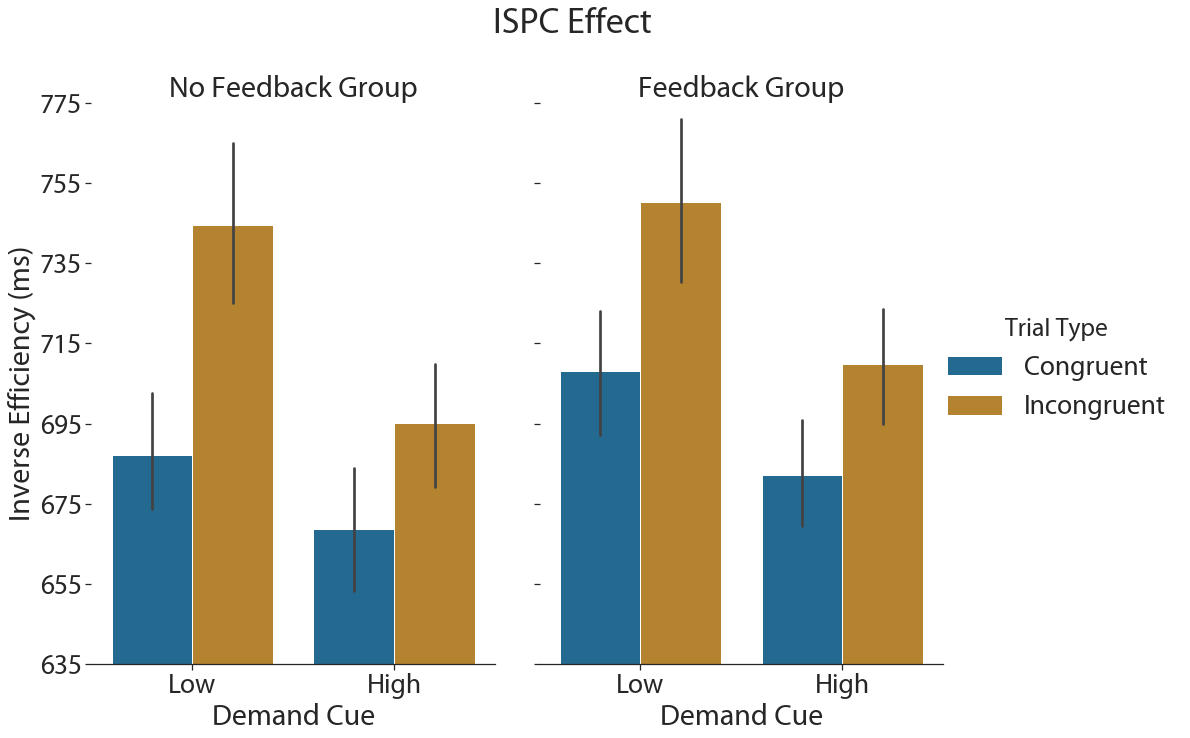

In [77]:
mybargraph("CueType","IE","TrialType","Feedback",["Low", "High"],IE_all,"Demand Cue","Inverse Efficiency (ms)","ISPC Effect","Trial Type",635,775,"ISPC_IE_maintask.png",20)

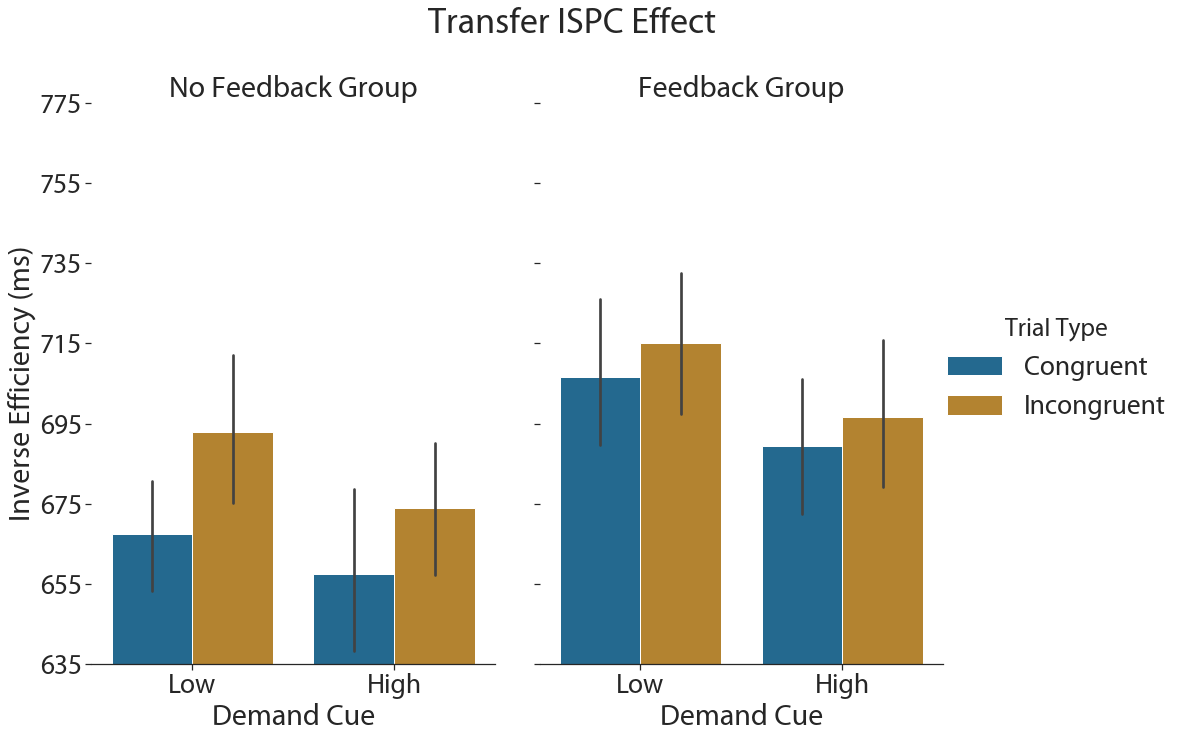

In [78]:
mybargraph("CueType","IE","TrialType","Feedback",["Low", "High"],IE_all_T,"Demand Cue","Inverse Efficiency (ms)","Transfer ISPC Effect","Trial Type",635,775,"ISPC_IE_transfertask.png",20)

In [79]:
%%writefile IE_Anova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawIEData <- read.csv('IE_Main.csv')

rawIEData$SubjectID = as.factor(rawIEData$SubjectID)
rawIEData$CueType = as.factor(rawIEData$CueType)
rawIEData$TrialType = as.factor(rawIEData$TrialType)
rawIEData$Feedback = as.factor(rawIEData$Feedback)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawIEData_T <- read.csv('IE_transfer.csv')

rawIEData_T$SubjectID = as.factor(rawIEData_T$SubjectID)
rawIEData_T$CueType = as.factor(rawIEData_T$CueType)
rawIEData_T$TrialType = as.factor(rawIEData_T$TrialType)
rawIEData_T$Feedback = as.factor(rawIEData_T$Feedback)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData_T),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

Overwriting IE_Anova.R


In [80]:
! Rscript IE_Anova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpsbvlK0\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpsbvlK0\downloaded_packages
$ANOVA
                      Effect DFn DFd          SSn       SSd            F
1                (Intercept)   1 118 2.390583e+08 6716002.8 4.200248e+03
2                   Feedback   1 118 2.260301e+04 6716002.8 3.971343e-01
3                    CueType   1 118 1.349978e+05  347269.2 4.587143e+01
5                  TrialType   1 118 1.774103e+05  282089.4 7.421198e+01
4           Feedback:CueType   1 118 2.247245e+01  347269.2 7.636004e-03
6         Feedback:TrialType   1 118 1.488741e+03  282089.4 6.227507e-01
7          CueType:TrialType   1 118 1.534566e+04  265254.1 6.826616e+00
8 Feedback:CueType:TrialType   1 118 2.003950e+03  265254.1 8.914702e-01
           

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


There is an interaction between cue & congruency for inverse efficiency for the main task, but not the transfer task. So that suggests that feedback has little influence on a standard ISPC effect, which we are replicating in both the No Feedback and Feedback groups. This replicates what we found in Experiment 1a, with a larger sample.

### Is there a correlation between the main ISPC effect and the transfer effect?

In Bugg and Dey (2018), this correlation was fairly small and observed when the N was large (i.e., across many expts). We may not see anything "stable" here for the No Feedback group (more comparable to Bugg and Dey, 2018), because our sample size is relatively small. Note that this is just an exploratory analysis that I was curious about, given the lack of a group-level transfer effect (e.g., if not observed at the group-level, are there individual differences?).

In [81]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue):
    sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=2, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

INVERSE EFFICIENCY

for the feedback group...?

(LinregressResult(slope=0.16567477068678085, intercept=-1.2910700567721658, rvalue=0.15168794357812118, pvalue=0.24728762069577875, stderr=0.14175439983410607),
 LinregressResult(slope=0.3075645247447302, intercept=-0.003203108139531459, rvalue=0.28759125167907706, pvalue=0.02587300626745198, stderr=0.13449316202270678))

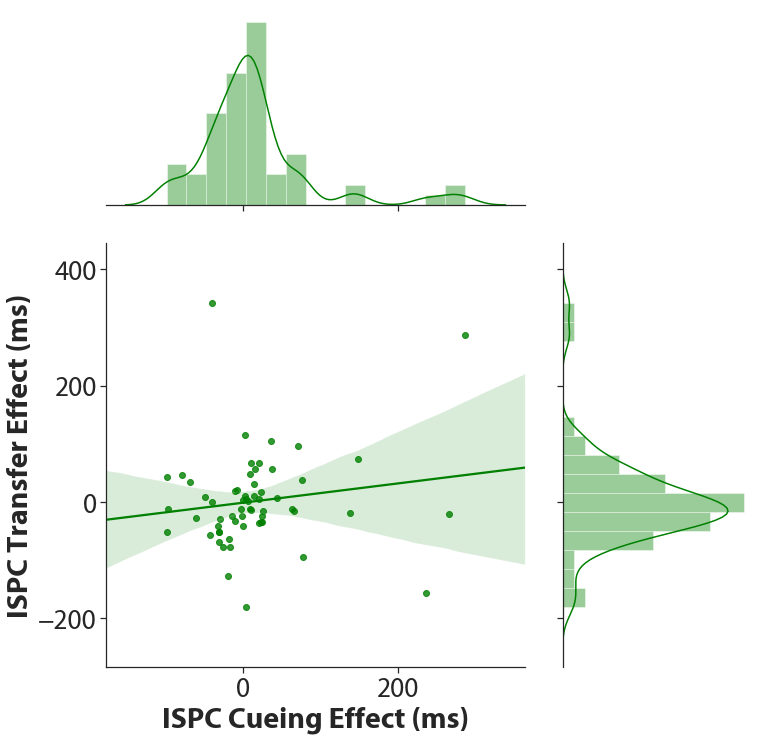

In [82]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="Feedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE_FB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="Feedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].OverallIE)

for the no feedback group...?

(LinregressResult(slope=0.004623522301218986, intercept=8.531921478336047, rvalue=0.004085659387410493, pvalue=0.9752840850890834, stderr=0.14859122995966645),
 LinregressResult(slope=0.05256937110565005, intercept=0.0033651061563266236, rvalue=0.05298198560457153, pvalue=0.6876500430883301, stderr=0.13010085338152064))

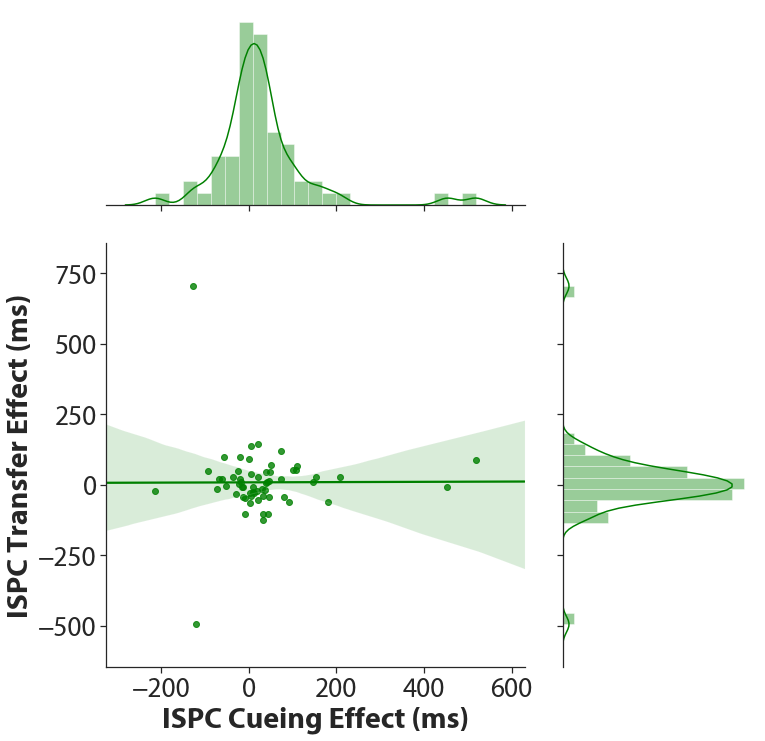

In [83]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE_NoFB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].OverallIE)

for all subjects...?

(LinregressResult(slope=0.05768675727021179, intercept=3.583400563005969, rvalue=0.05168752819371084, pvalue=0.5750313781342031, stderr=0.10260498289575448),
 LinregressResult(slope=0.1364867647131884, intercept=-0.00027555224717150514, rvalue=0.134777281343608, pvalue=0.14219580473421706, stderr=0.09237450355537553))

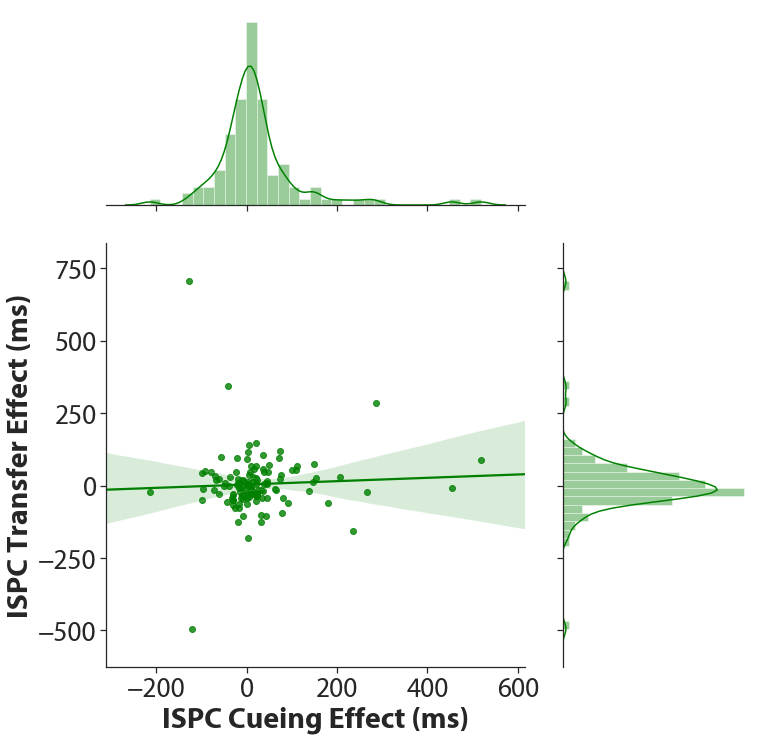

In [84]:
my_corr_graphs(avgIEmain.Effect, avgIE_T.Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE.png", 1, avgIEmain.OverallIE, avgIE_T.OverallIE)

REACTION TIME

for the feedback group...?

(LinregressResult(slope=0.40942615244911706, intercept=-4.321934047376756, rvalue=0.3996983969077895, pvalue=0.0015565430845233953, stderr=0.12329093924944988),
 LinregressResult(slope=0.41698706695436777, intercept=-0.00619552318562353, rvalue=0.4148271531168054, pvalue=0.000982513740921916, stderr=0.12009783778090728))

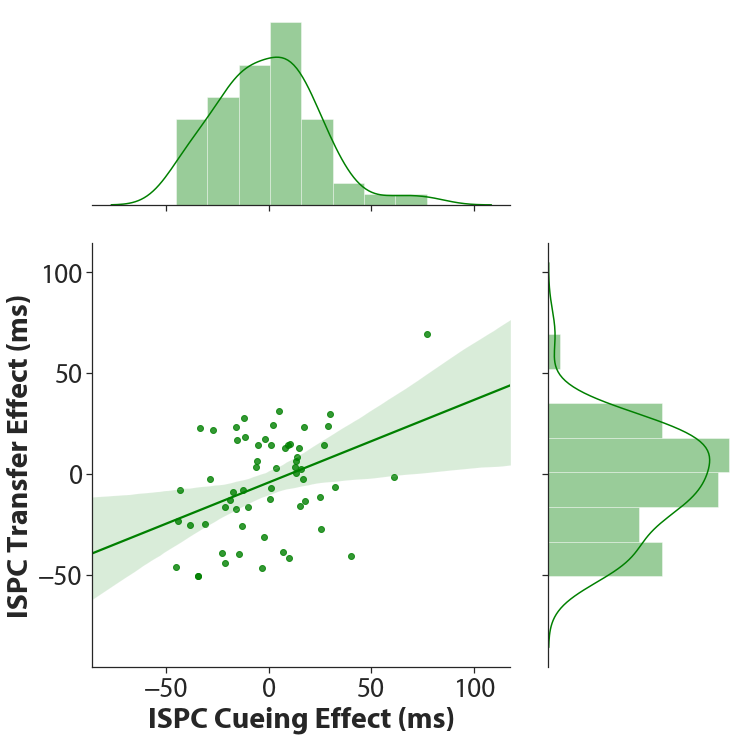

In [85]:
my_corr_graphs(SC_RT_FB.RTs, SCT_RT_FB.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_FB.png", 1, MainRT_FB.RT, RT_FB_T.RT)

for the no feedback group...?

(LinregressResult(slope=0.15111293742153065, intercept=0.42634248068460223, rvalue=0.1415538220042176, pvalue=0.28065484922189554, stderr=0.13876207416410596),
 LinregressResult(slope=0.1833115478840611, intercept=5.867639934972616e-05, rvalue=0.16164784682069971, pvalue=0.2172352260070819, stderr=0.14694553407545174))

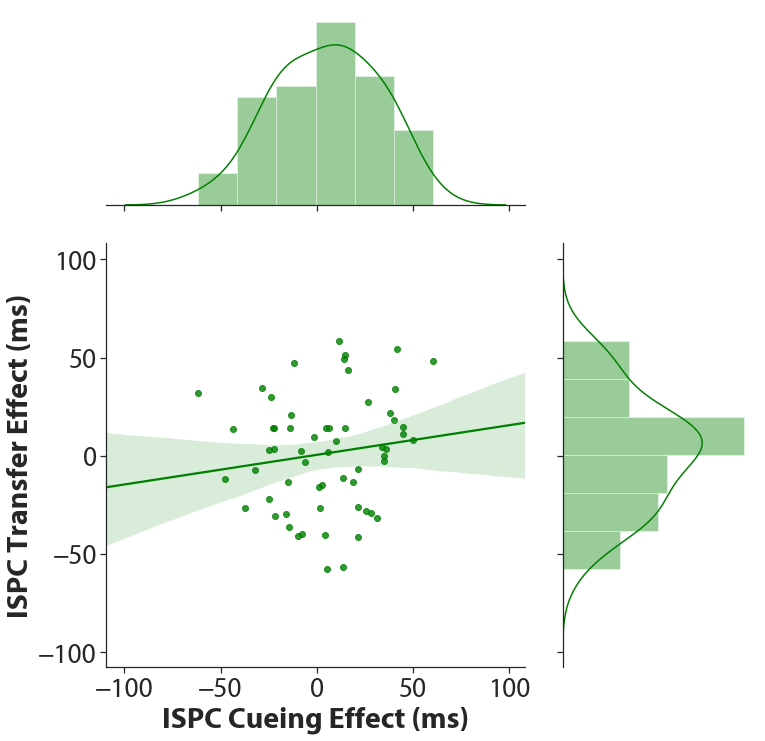

In [86]:
my_corr_graphs(SC_RT_NoFB.RTs, SCT_RT_NoFB.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_NoFB.png", 1, MainRT_NoFB.RT, RT_NoFB_T.RT)

across all subjects...?

(LinregressResult(slope=0.27810512492270906, intercept=-2.322796020966357, rvalue=0.26551296507904315, pvalue=0.003379799197534912, stderr=0.09296246313069692),
 LinregressResult(slope=0.2972354895799174, intercept=-0.003598410929306728, rvalue=0.2764853404323011, pvalue=0.002236656973667001, stderr=0.09510845628538082))

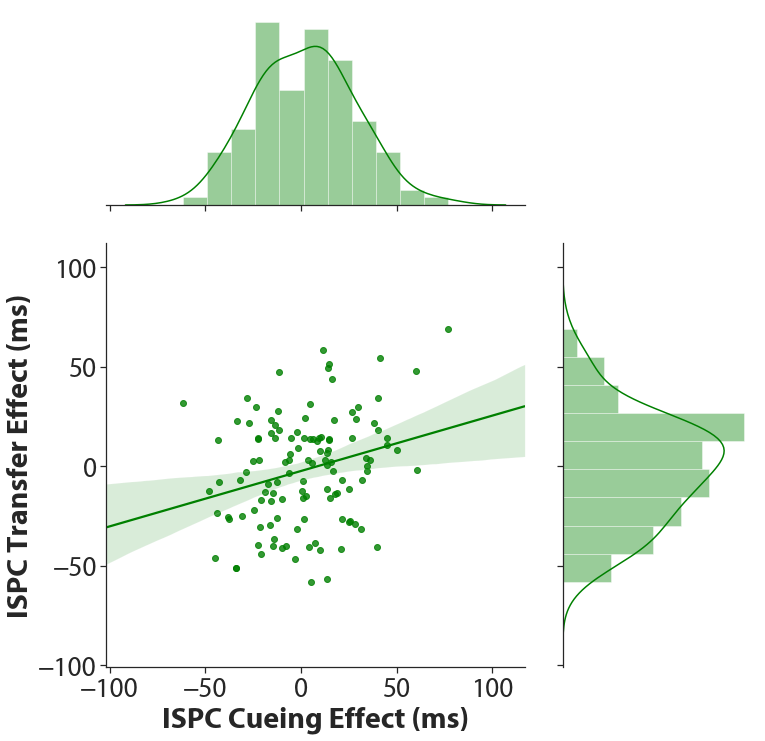

In [87]:
my_corr_graphs(SC_RT.RTs, SCT_RT.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All.png", 0, overallMainRT.RT, overallRT_T.RT)

So, there is some hint of a correlation between the cueing & transfer effects for RT for the feedback group. In E1a, we found hints of a relationship for the no feedback group. Here, it is coming out to be significant, when correcting for overall RT, across all subjects - i.e., not modulated by feedback. Which is what would be expected if feedback doesn't really impact the ISPC. Also, correlations don't stabilize until ~200-250 subjects, so we're underpowered here as well.

ACCURACY

... for the feedback group?

(LinregressResult(slope=0.050315565273009684, intercept=-0.004429759535013952, rvalue=0.042347544414882726, pvalue=0.7480084099318468, stderr=0.15587280984686802),
 LinregressResult(slope=0.032323960372627816, intercept=-0.006242823489128047, rvalue=0.025961428756823092, pvalue=0.8439063936966592, stderr=0.16343142729639876))

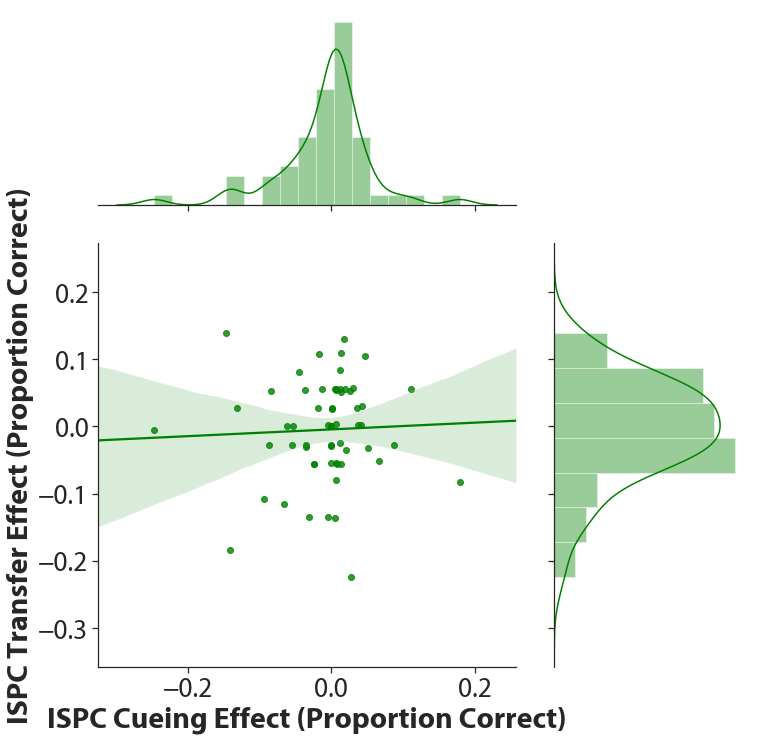

In [88]:
my_corr_graphs(SC_ACC_FB.ACC, SCT_ACC_FB.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_FB_ACC.png", 1, MainACC_FB.Accuracy, ACC_FB_T.Accuracy)

... for the no feedback group?

(LinregressResult(slope=-0.005701251107178336, intercept=-0.002591999047115073, rvalue=-0.005667829947122725, pvalue=0.9657177904814486, stderr=0.13207857827574154),
 LinregressResult(slope=-0.04004913867054187, intercept=-0.005277333601994521, rvalue=-0.03617321299446099, pvalue=0.783783330466762, stderr=0.14528065002927573))

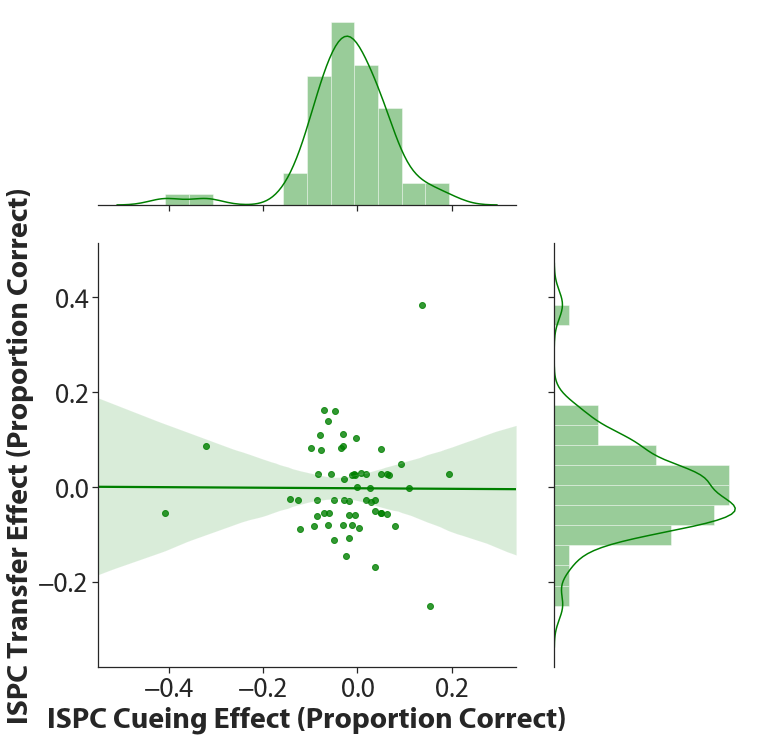

In [89]:
my_corr_graphs(SC_ACC_NoFB.ACC, SCT_ACC_NoFB.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_NoFB_ACC.png", 1, MainACC_NoFB.Accuracy, ACC_NoFB_T.Accuracy)

... for all subjects?

(LinregressResult(slope=0.010437633830913218, intercept=-0.0035113948574875885, rvalue=0.009821939338384458, pvalue=0.915209189238266, stderr=0.09782342324941395),
 LinregressResult(slope=-0.018935757161801615, intercept=-0.005773491661509765, rvalue=-0.016497159434696252, pvalue=0.8580649583788492, stderr=0.10565094698674372))

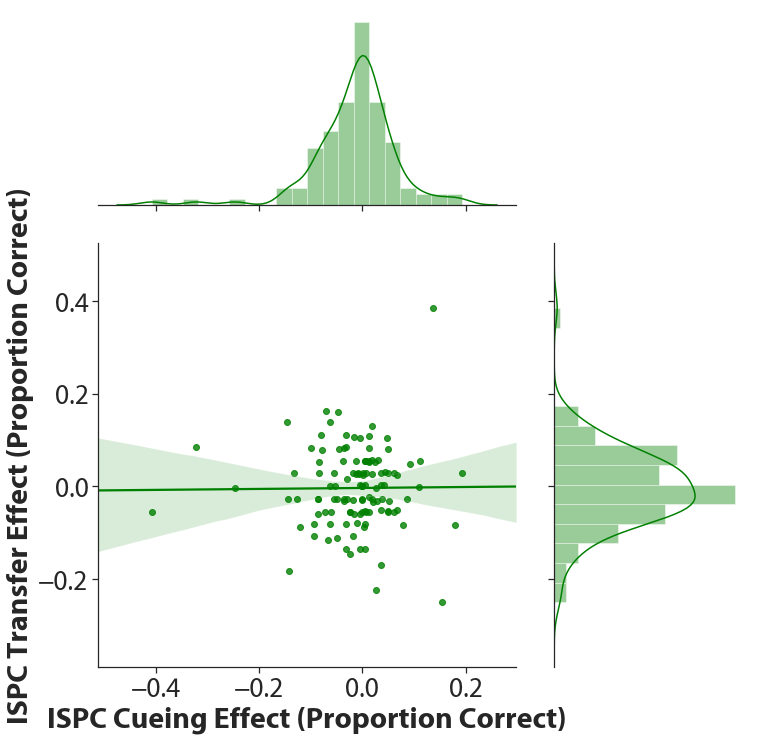

In [90]:
my_corr_graphs(SC_ACC.ACC, SCT_ACC.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_All_ACC.png", 0, overallMainACC.Accuracy, overallACC_T.Accuracy)

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [91]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=2)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [92]:
def ci_effects(df, dv, Filter1, Filter2, Context):
    if Context == 1:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
   
    return sub_means

In [93]:
def make_ci_table(df, dv, Filter1, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Filter1, Filter2, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Filter1, Filter2, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)

    x2 = ci_effects(df, dv, Filter1, Filter3, Context);
    r4_MIC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighIC'][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighC'][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowIC'][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowC'][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1 (Main)': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2 (Main)': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3 (Main)': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Overall (Main)': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC],
                     'Run 4 (Transfer)': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

First, let's look at the typical ISPC paradigm group.

In [94]:
make_ci_table(cdat, 'RT', 'NoFeedback', 'MainTask', 'TransferTask', 1, 2, 0, 'NoFBSupplementaryTable1.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(632.0, [615.0, 649.0])","(625.0, [608.0, 642.0])","(632.0, [615.0, 649.0])","(630.0, [613.0, 646.0])","(617.0, [601.0, 633.0])"
1,MC.IC,"(654.0, [637.0, 671.0])","(645.0, [628.0, 663.0])","(640.0, [622.0, 658.0])","(647.0, [630.0, 663.0])","(626.0, [609.0, 642.0])"
2,MIC.C,"(627.0, [606.0, 647.0])","(613.0, [595.0, 630.0])","(622.0, [605.0, 639.0])","(620.0, [602.0, 638.0])","(611.0, [593.0, 628.0])"
3,MIC.IC,"(639.0, [620.0, 657.0])","(627.0, [609.0, 644.0])","(632.0, [615.0, 650.0])","(632.0, [615.0, 649.0])","(618.0, [601.0, 635.0])"


And now what about the feedback group for RT?

In [95]:
make_ci_table(cdat, 'RT', 'Feedback', 'MainTask', 'TransferTask', 1, 2, 0, 'FBSupplementaryTable2.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(662.0, [641.0, 683.0])","(651.0, [631.0, 672.0])","(650.0, [629.0, 671.0])","(654.0, [634.0, 674.0])","(648.0, [627.0, 670.0])"
1,MC.IC,"(679.0, [658.0, 700.0])","(666.0, [645.0, 686.0])","(660.0, [639.0, 680.0])","(668.0, [648.0, 687.0])","(652.0, [632.0, 673.0])"
2,MIC.C,"(651.0, [629.0, 672.0])","(633.0, [613.0, 653.0])","(638.0, [618.0, 658.0])","(640.0, [621.0, 660.0])","(634.0, [614.0, 655.0])"
3,MIC.IC,"(664.0, [643.0, 684.0])","(649.0, [630.0, 669.0])","(652.0, [633.0, 671.0])","(654.0, [635.0, 674.0])","(643.0, [623.0, 663.0])"


And for Accuracy, first for the typical ISPC group...

In [96]:
make_ci_table(adat, 'Accuracy', 'NoFeedback', 'MainTask', 'TransferTask', 1, 2, 1, 'NoFB_ACC_SupplementaryTable3.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(0.92, [0.89, 0.94])","(0.93, [0.91, 0.95])","(0.93, [0.92, 0.95])","(0.93, [0.91, 0.94])","(0.93, [0.91, 0.95])"
1,MC.IC,"(0.87, [0.84, 0.91])","(0.9, [0.87, 0.93])","(0.89, [0.86, 0.91])","(0.89, [0.86, 0.91])","(0.92, [0.9, 0.94])"
2,MIC.C,"(0.93, [0.9, 0.95])","(0.94, [0.91, 0.96])","(0.95, [0.93, 0.97])","(0.94, [0.92, 0.96])","(0.95, [0.92, 0.97])"
3,MIC.IC,"(0.9, [0.87, 0.92])","(0.93, [0.91, 0.95])","(0.93, [0.91, 0.95])","(0.92, [0.9, 0.94])","(0.93, [0.91, 0.95])"


And now for the feedback group...

In [97]:
make_ci_table(adat, 'Accuracy', 'Feedback', 'MainTask', 'TransferTask', 1, 2, 1, 'FB_ACC_SupplementaryTable4.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(0.92, [0.9, 0.93])","(0.94, [0.92, 0.95])","(0.94, [0.92, 0.95])","(0.93, [0.92, 0.94])","(0.93, [0.91, 0.95])"
1,MC.IC,"(0.87, [0.83, 0.9])","(0.92, [0.9, 0.94])","(0.93, [0.91, 0.95])","(0.91, [0.88, 0.93])","(0.93, [0.91, 0.95])"
2,MIC.C,"(0.93, [0.91, 0.95])","(0.95, [0.93, 0.97])","(0.95, [0.93, 0.97])","(0.94, [0.93, 0.96])","(0.93, [0.91, 0.95])"
3,MIC.IC,"(0.91, [0.89, 0.93])","(0.94, [0.92, 0.95])","(0.94, [0.93, 0.96])","(0.93, [0.91, 0.94])","(0.93, [0.92, 0.95])"


# Post-test Questionnaire Data

This was to assess participant awareness of the task manipulations.

In [98]:
%cd ..

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispcfb_rep\data


In [99]:
posttest = pd.read_csv('posttest.csv')

In [100]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [101]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences.

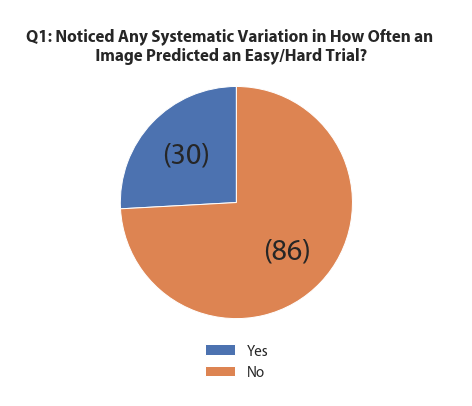

In [102]:
fig, ax1 = plt.subplots(figsize=(8, 7));
Q1 = [posttest.Q1_SC_SystematicVariation[posttest.Q1_SC_SystematicVariation == 1].count(), posttest.Q1_SC_SystematicVariation[posttest.Q1_SC_SystematicVariation == 0].count()];
Q1labels = ['Yes','No'];
plt.axis('equal');
startanglept=90;
radiussize=0.65;
legendfontsize=15;
titlefontsize=17;

patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
fig.suptitle('Q1: Noticed Any Systematic Variation in How Often an\n Image Predicted an Easy/Hard Trial?', fontsize=titlefontsize,fontweight="bold", y = 0.85);
plb.savefig(figurepath+"posttestQ1_SC.png", bbox_inches='tight');

#### Next, we asked participants to rate how likely certain images would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were the bear and bird paired together? Bear and deer? Bear and turtle?

Were any of the image category pairings rated as more predictive or nonpredictive than chance (50%)?

In [103]:
stats.ttest_1samp(posttest.Q2_BearTurtle.dropna(),50)

Ttest_1sampResult(statistic=-0.7756838712930748, pvalue=0.43955604553119265)

In [104]:
stats.ttest_1samp(posttest.Q2_BearBird.dropna(),50)

Ttest_1sampResult(statistic=0.5435587353846523, pvalue=0.5878159153097777)

In [105]:
stats.ttest_1samp(posttest.Q2_BearDeer.dropna(),50)

Ttest_1sampResult(statistic=1.690005899218312, pvalue=0.09383348536413856)

In versions 1 and 7, the bear and turtle were paired together (as the mostly congruent context).
In versions 2 and 8, the bear and deer were paired together (as the mostly congruent context).
In versions 3 and 9, the bear and turtle were paired together (as the mostly incongruent context).
In versions 4 and 10, the bear and deer were paired together (as the mostly incongruent context).
In versions 5 and 11, the bear and bird were paired together (as the mostly congruent context).
In versions 6 and 12, the bear and bird were paired together (as the mostly incongruent context).

In [106]:
posttest['Group'] = posttest['version'].isin([1,2,3,4])
posttest.loc[posttest['version'].isin([1,7,3,9]),'Group'] = 'BearTurtle'
posttest.loc[posttest['version'].isin([2,8,4,10]),'Group'] = 'BearDeer'
posttest.loc[posttest['version'].isin([5,6,11,12]),'Group'] = 'BearBird'

Does any one group differ in how it rates the image categories? E.g., the "BearDeer" group could rate the bear + deer clustering as more predictive than the other 2 groups.

In [107]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod_BT = ols('Q2_BearTurtle ~ Group',
                data=posttest).fit()
                
aov_table_BT = sm.stats.anova_lm(mod_BT, typ=2)
print(aov_table_BT)

                sum_sq     df         F    PR(>F)
Group       444.659664    2.0  0.446023  0.641311
Residual  55330.357880  111.0       NaN       NaN


In [108]:
posttest.groupby(['Group'])['Q2_BearTurtle'].mean()

Group
BearBird      46.459459
BearDeer      47.564103
BearTurtle    51.105263
Name: Q2_BearTurtle, dtype: float64

In [109]:
mod_BB = ols('Q2_BearBird ~ Group',
                data=posttest).fit()
                
aov_table_BB = sm.stats.anova_lm(mod_BB, typ=2)
print(aov_table_BB)

                sum_sq     df        F    PR(>F)
Group      1391.520826    2.0  1.41868  0.246387
Residual  54437.505489  111.0      NaN       NaN


In [110]:
posttest.groupby(['Group'])['Q2_BearBird'].mean()

Group
BearBird      46.108108
BearDeer      53.205128
BearTurtle    53.894737
Name: Q2_BearBird, dtype: float64

In [111]:
mod_BD = ols('Q2_BearDeer ~ Group',
                data=posttest).fit()
                
aov_table_BD = sm.stats.anova_lm(mod_BD, typ=2)
print(aov_table_BD)

                sum_sq     df        F    PR(>F)
Group      1059.406434    2.0  0.95524  0.387917
Residual  60443.084637  109.0      NaN       NaN


In [112]:
posttest.groupby(['Group'])['Q2_BearDeer'].mean()

Group
BearBird      57.729730
BearDeer      50.236842
BearTurtle    53.405405
Name: Q2_BearDeer, dtype: float64

In [113]:
GRP_BT = posttest.groupby(['subjID'])['Q2_BearTurtle'].mean()
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = posttest.groupby(['subjID'])['Q2_BearBird'].mean()
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = posttest.groupby(['subjID'])['Q2_BearDeer'].mean()
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))

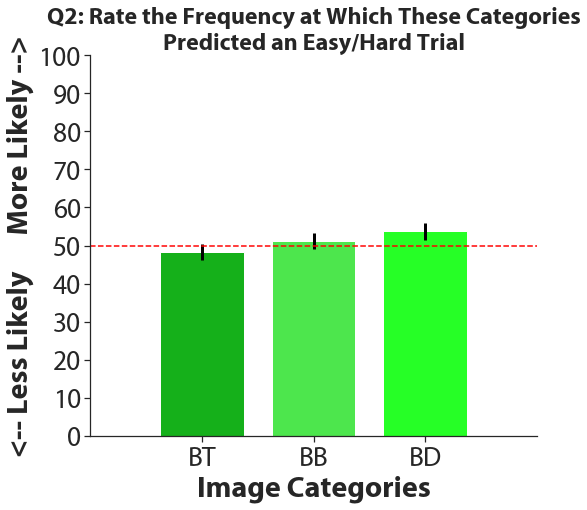

In [114]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
plt.plot([0,1,2,3,4],[50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.3,0.9,0.3),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,4);
ax.set_xticklabels(('BT','BB','BD'));
ax.set_xticks([1, 2, 3]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which These Categories\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Image Categories',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the images to the Stroop trial type that they most likely predicted. Did they perform better than chance (i.e., 2/4 cue-demand relationships correctly matched)? They were asked this for both the main task ISPC items (SC_ForcedChoice) and the transfer task items (SCT_ForcedChoice). We can then compare their performance matching between the transfer items (which were nonpredictive) and the main task items (which were predictive).

In [115]:
stats.ttest_1samp(posttest.Q3_SC_ForcedChoicePerformance.dropna(),2)

Ttest_1sampResult(statistic=-6.002777373008672, pvalue=2.3988825137544066e-08)

In [116]:
stats.ttest_1samp(posttest.Q3_SCT_ForcedChoicePerformance.dropna(),2)

Ttest_1sampResult(statistic=-2.4710135129091917, pvalue=0.014965578470048297)

In [117]:
ttest = stats.ttest_rel(posttest.Q3_SC_ForcedChoicePerformance.dropna(), posttest.Q3_SCT_ForcedChoicePerformance.dropna())
d = cohen_d(posttest.Q3_SC_ForcedChoicePerformance.dropna(), posttest.Q3_SCT_ForcedChoicePerformance.dropna())
ttest, d

(Ttest_relResult(statistic=-2.349446822353497, pvalue=0.020537517000329082),
 -0.259345387542935)

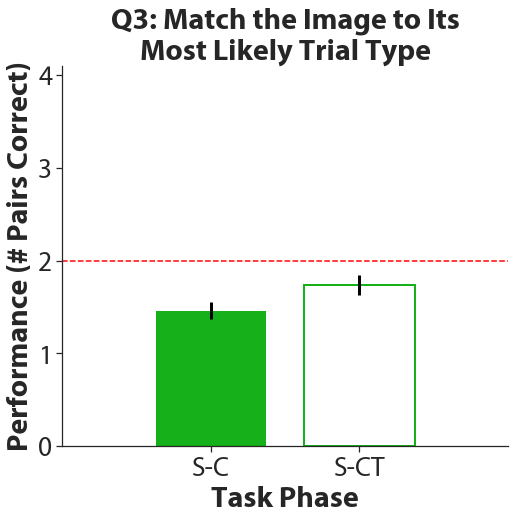

In [118]:
SCFC = posttest.groupby(['subjID'])['Q3_SC_ForcedChoicePerformance'].mean();
SCFCSEM = pd.Series.std(SCFC.dropna()) / sqrt(len(SCFC.dropna()));
SCTFC = posttest.groupby(['subjID'])['Q3_SCT_ForcedChoicePerformance'].mean();
SCTFCSEM = pd.Series.std(SCTFC.dropna()) / sqrt(len(SCTFC.dropna()));

barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
rects1 = ax.bar(1,SCFC.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=SCFCSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(2,SCTFC.dropna().mean(),barwidth,yerr=SCTFCSEM,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2,facecolor='none', error_kw=dict(lw=3));
ax.set_ylim(0,4.1);
ax.set_xlim(0,3);
plt.plot([0,1,2,3],[2,2,2,2], 'r--');
ax.set_xticklabels(('S-C','S-CT'));
ax.set_xticks([1, 2]);
ax.set_yticks(np.arange(0, 5, 1));
plt.title('Q3: Match the Image to Its\nMost Likely Trial Type', fontweight="bold");
plt.ylabel('Performance (# Pairs Correct)', fontweight="bold");
plt.xlabel('Task Phase', fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ3.png", bbox_inches='tight');

# Exploratory Analysis of the Congruency Sequence Effect

This experiment was primarily designed to look at the effects of performance feedback on the ISPC. Here, this is just me satisfying my curiosity with an exploratory analysis of the CSE.

The CSE is also theorized to be sensitive to reward (Abrahamse et al., 2016). Thus, although the trial design is limited (not all the trial types have equal percentages), we can somewhat assess the effects of FB on the CSE.

In [119]:
rdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1) & (TrialCounter != 1)').copy()
acdat = dat.query('(TrialCounter != 1)').copy()

In [120]:
dataframes = [rdat, acdat];

for df in dataframes:
    df['Feedback'] = df['Version'].isin([7,8,9,10,11,12])
    df.loc[df['Version'].isin([7,8,9,10,11,12]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([1,2,3,4,5,6]), 'Feedback'] = 'NoFeedback'
    
    df['Transfer'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2,3]), 'Transfer'] = 'MainTask'
    df.loc[df['RunCounter'].isin([4]), 'Transfer'] = 'TransferTask'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['PrevCong'] = df['Prevtrial'].isin([1])
    df.loc[df['Prevtrial'].isin([1]),'PrevCong'] = 'Incongruent'
    df.loc[~df['Prevtrial'].isin([1]),'PrevCong'] = 'Congruent'
    
    df['CSE'] = df['Sequential'].isin([1])
    df.loc[df['Sequential'].isin([1]),'CSE'] = 'Cong-Cong'
    df.loc[df['Sequential'].isin([2]),'CSE'] = 'Incong-Cong'
    df.loc[df['Sequential'].isin([3]),'CSE'] = 'Cong-Incong'
    df.loc[df['Sequential'].isin([4]),'CSE'] = 'Incong-Incong'

Let's take a peak at the means...

In [121]:
mean_cueing_effect(rdat, 'RT', 'Feedback', 'MainTask',0)

(CSE
 Cong-Cong        648.216856
 Cong-Incong      656.871980
 Incong-Cong      651.821720
 Incong-Incong    658.059806
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.090173
 Cong-Incong      4.806489
 Incong-Cong      4.952682
 Incong-Incong    4.781031
 Name: RT, dtype: float64)

In [122]:
mean_cueing_effect(rdat, 'RT', 'NoFeedback', 'MainTask',0)

(CSE
 Cong-Cong        627.823807
 Cong-Incong      635.504552
 Incong-Cong      626.073008
 Incong-Incong    635.160869
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.251906
 Cong-Incong      4.202917
 Incong-Cong      4.196627
 Incong-Incong    4.237156
 Name: RT, dtype: float64)

In [123]:
mean_cueing_effect(acdat, 'Accuracy', 'Feedback', 'MainTask',0)

(CSE
 Cong-Cong        0.935566
 Cong-Incong      0.925356
 Incong-Cong      0.933754
 Incong-Incong    0.922991
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.003438
 Cong-Incong      0.003705
 Incong-Cong      0.003137
 Incong-Incong    0.004297
 Name: Accuracy, dtype: float64)

In [124]:
mean_cueing_effect(acdat, 'Accuracy', 'NoFeedback', 'MainTask',0)

(CSE
 Cong-Cong        0.933635
 Cong-Incong      0.910358
 Incong-Cong      0.925515
 Incong-Incong    0.914639
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.004149
 Cong-Incong      0.004643
 Incong-Cong      0.004459
 Incong-Incong    0.005164
 Name: Accuracy, dtype: float64)

What about transfer?

In [125]:
mean_cueing_effect(rdat, 'RT', 'Feedback', 'TransferTask',0)

(CSE
 Cong-Cong        649.676553
 Cong-Incong      642.943252
 Incong-Cong      634.453011
 Incong-Incong    651.369288
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.363406
 Cong-Incong      5.019083
 Incong-Cong      5.182980
 Incong-Incong    5.084321
 Name: RT, dtype: float64)

In [126]:
mean_cueing_effect(rdat, 'RT', 'NoFeedback', 'TransferTask',0)

(CSE
 Cong-Cong        618.329171
 Cong-Incong      615.603824
 Incong-Cong      608.605097
 Incong-Incong    628.407865
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.215003
 Cong-Incong      4.212056
 Incong-Cong      4.207256
 Incong-Incong    4.274132
 Name: RT, dtype: float64)

In [127]:
mean_cueing_effect(acdat, 'Accuracy', 'Feedback', 'TransferTask',0)

(CSE
 Cong-Cong        0.917245
 Cong-Incong      0.937319
 Incong-Cong      0.944369
 Incong-Incong    0.925357
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005635
 Cong-Incong      0.005120
 Incong-Cong      0.004020
 Incong-Incong    0.004965
 Name: Accuracy, dtype: float64)

In [128]:
mean_cueing_effect(acdat, 'Accuracy', 'NoFeedback', 'TransferTask',0)

(CSE
 Cong-Cong        0.931636
 Cong-Incong      0.936710
 Incong-Cong      0.947285
 Incong-Incong    0.912461
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.004635
 Cong-Incong      0.004929
 Incong-Cong      0.005110
 Incong-Incong    0.005498
 Name: Accuracy, dtype: float64)

OK, let's actually analyze the main task data... Note that there aren't enough trials for transfer analysis.
(Also why this is so exploratory - again the expt was not designed for this.)

In [129]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispcfb_rep\data\csvdata


In [130]:
CSE_RT = rdat.loc[rdat['Transfer'] == 'MainTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC = acdat.loc[acdat['Transfer'] == 'MainTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

CSE_RT_T = rdat.loc[rdat['Transfer'] == 'TransferTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC_T = acdat.loc[acdat['Transfer'] == 'TransferTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

#create tidy data csvs
CSE_RT.to_csv(csvpath+'CSE_ANOVA_RT.csv')
CSE_ACC.to_csv(csvpath+'CSE_ANOVA_ACC.csv')
CSE_RT_T.to_csv(csvpath+'CSE_ANOVA_RT_T.csv')
CSE_ACC_T.to_csv(csvpath+'CSE_ANOVA_ACC_T.csv')

In [131]:
%%writefile CSEAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

CSE_RT <- read.csv('CSE_ANOVA_RT.csv')

CSE_RT$subject = as.factor(CSE_RT$subject)
CSE_RT$Feedback = as.factor(CSE_RT$Feedback)
CSE_RT$PrevCong = as.factor(CSE_RT$PrevCong)
CSE_RT$Congruency = as.factor(CSE_RT$Congruency)

CSERT_AN <- ezANOVA(data=as.data.frame(CSE_RT),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSERT_AN)

#

CSE_ACC <- read.csv('CSE_ANOVA_ACC.csv')

CSE_ACC$subject = as.factor(CSE_ACC$subject)
CSE_ACC$Feedback = as.factor(CSE_ACC$Feedback)
CSE_ACC$PrevCong = as.factor(CSE_ACC$PrevCong)
CSE_ACC$Congruency = as.factor(CSE_ACC$Congruency)

CSEACC_AN <- ezANOVA(data=as.data.frame(CSE_ACC),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSEACC_AN)

Overwriting CSEAnova.R


In [132]:
! Rscript CSEAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpSCQPxH\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpSCQPxH\downloaded_packages
$ANOVA
                        Effect DFn DFd          SSn        SSd            F
1                  (Intercept)   1 118 1.981110e+08 2316176.18 1.009297e+04
2                     Feedback   1 118 6.130222e+04 2316176.18 3.123105e+00
3                     PrevCong   1 118 5.460246e+01   11200.64 5.752429e-01
5                   Congruency   1 118 7.518529e+03   33361.66 2.659299e+01
4            Feedback:PrevCong   1 118 3.557485e+02   11200.64 3.747850e+00
6          Feedback:Congruency   1 118 2.637834e+01   33361.66 9.330005e-02
7          PrevCong:Congruency   1 118 7.649598e+00   14005.40 6.445032e-02
8 Feedback:PrevCong:Congruency   1 118 1.096812e+02   14005.

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Let's look at the graphs...

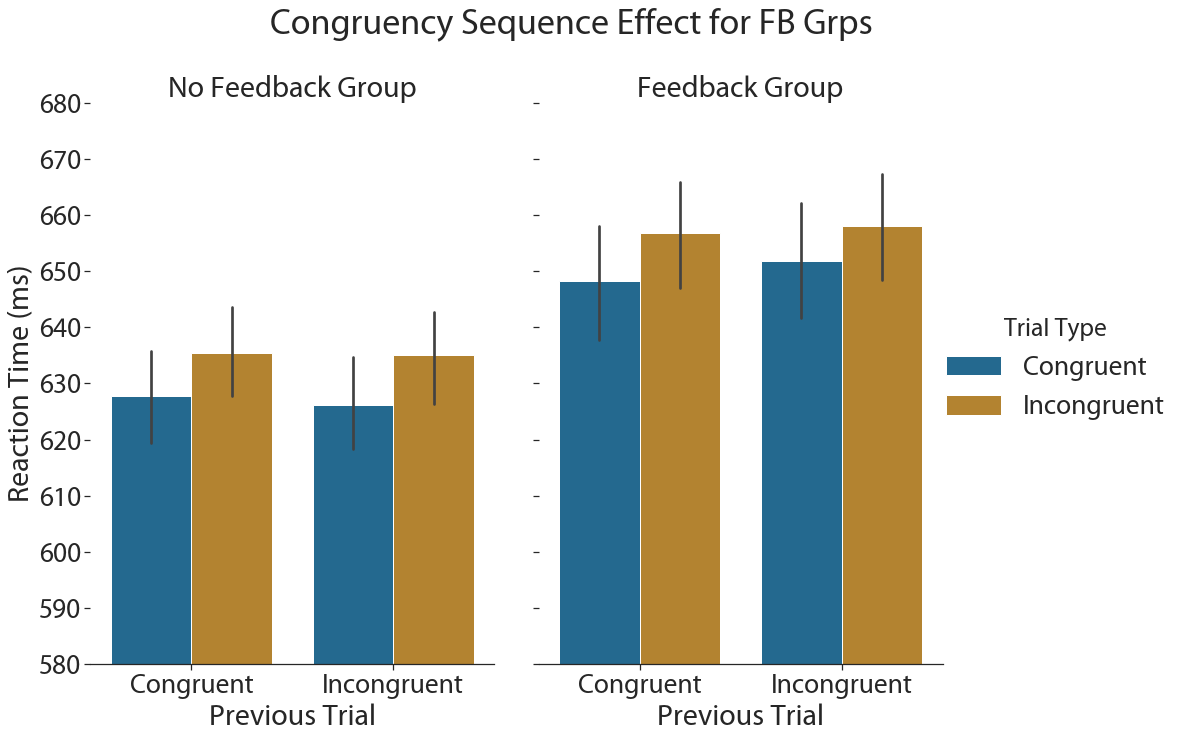

In [134]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect for FB Grps","Trial Type",580,680,"CSE_RT.png",10)

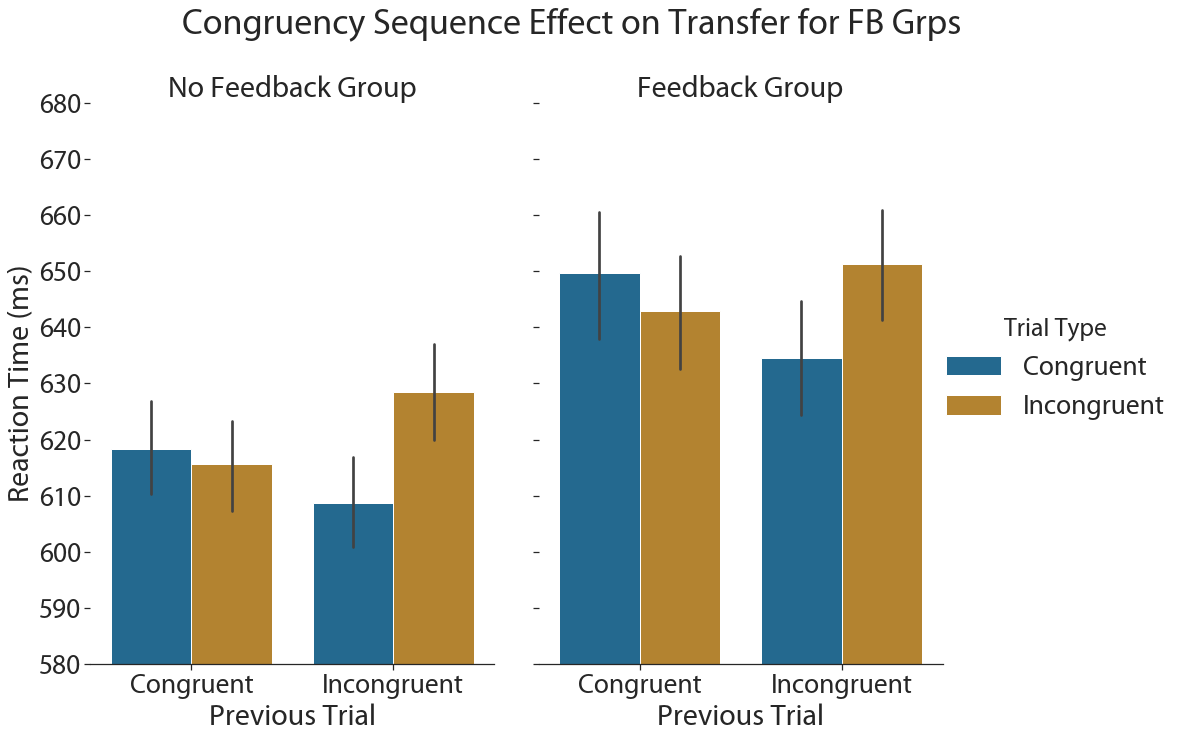

In [135]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT_T,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect on Transfer for FB Grps","Trial Type",580,680,"CSE_RT_T.png",10)

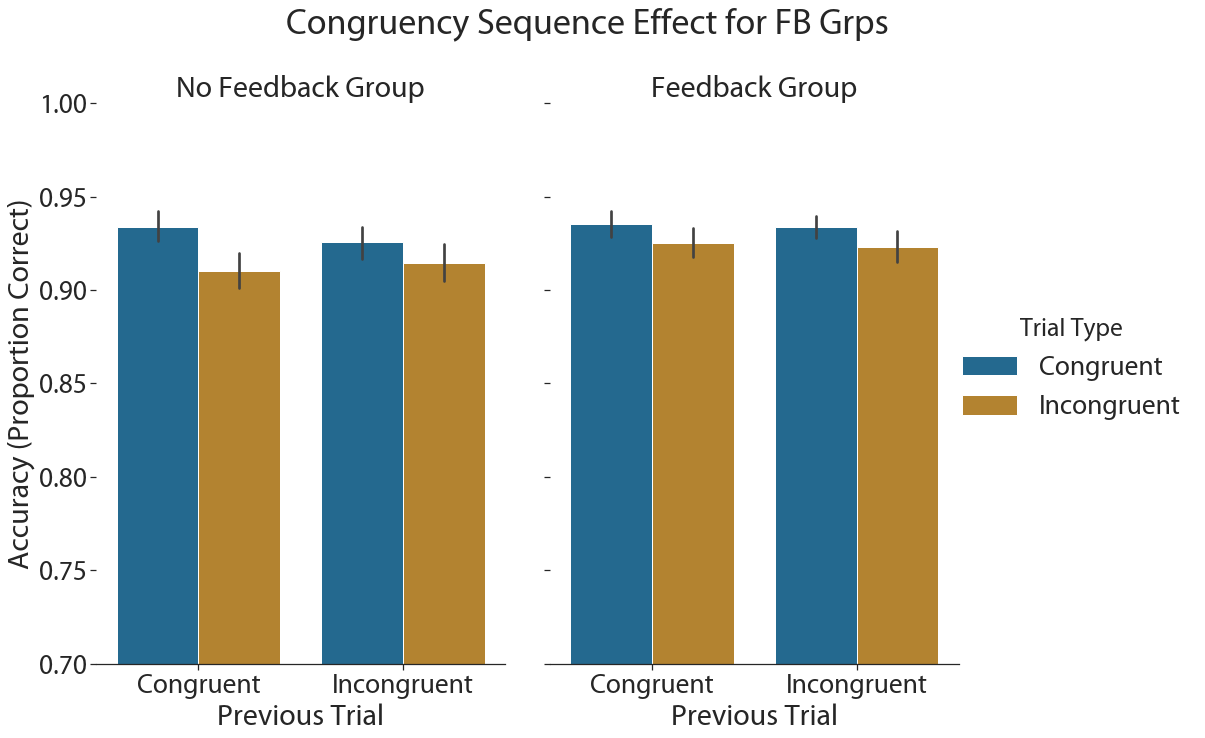

In [136]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect for FB Grps","Trial Type",0.7,1.0,"CSE_ACC.png",0.05)

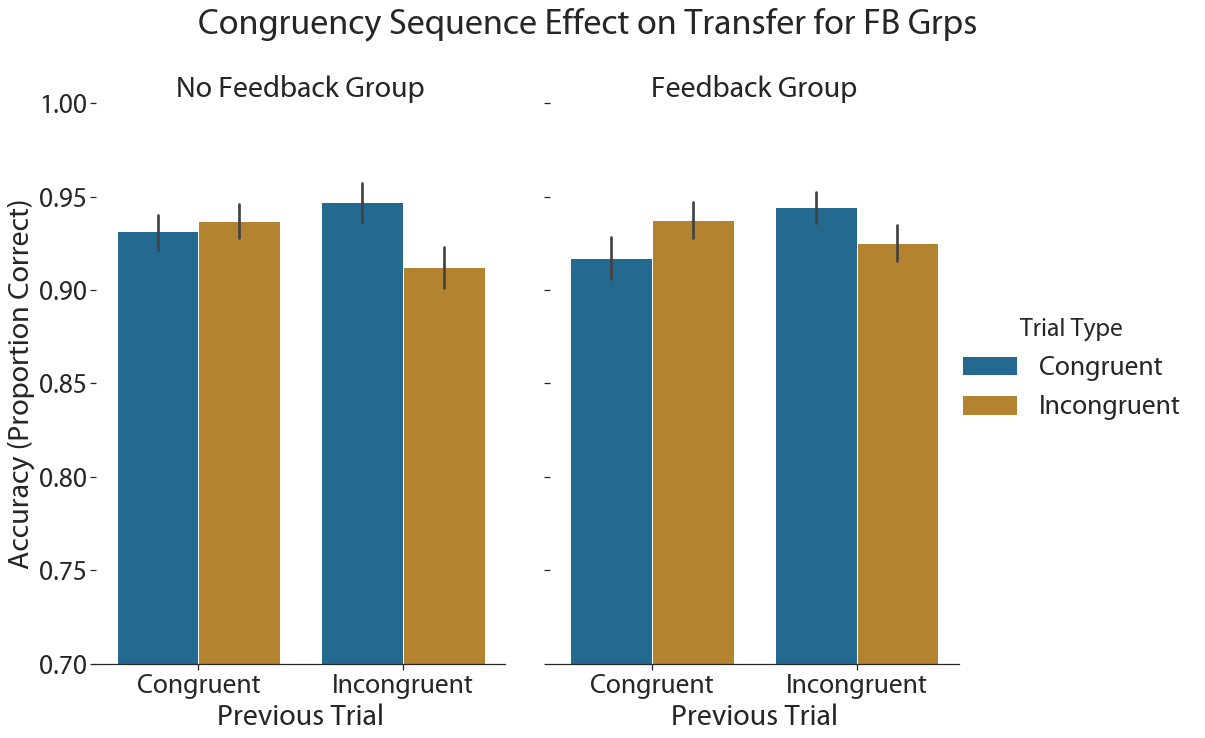

In [137]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC_T,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect on Transfer for FB Grps","Trial Type",0.7,1.0,"CSE_ACC_T.png",0.05)